In [1]:
import sys
sys.path.append('../src')
from preamble import *
figure_path = os.path.join(root_dir,'reports','figures')

# get data files
files_dict = walk_directory(raw_data)
drews_data = list(files_dict.keys())
drews_data.remove('pump')
#drews_data.remove('Andrew_sleep') # not tracked

Andrew_nursing /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_nursing.csv
Andrew_sleep /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_sleep.csv
Andrew_diaper /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_diaper.csv
Andrew_temperature /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_temperature.csv
pump /home/jgalloway/github/andrews_baby_tracker/data/raw/pump.csv
Andrew_formula /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_formula.csv
wtageinf /home/jgalloway/github/andrews_baby_tracker/data/raw/wtageinf.csv
Andrew_other_activity /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_other_activity.csv
Andrew_growth /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_growth.csv
Andrew_milestone /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_milestone.csv
Andrew_expressed /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_expressed.csv


CDC Data for weight [here](https://www.cdc.gov/growthcharts/percentile_data_files.htm)

In [2]:
from datetime import timedelta,datetime
def get_data(filename):
    return (pd.read_csv(filename)
             .drop(columns=['Baby'])
             .assign(Time= lambda x: pd.to_datetime(x.Time))
             .set_index('Time',drop=True))

def get_days_between(datePast, dateFuture):
   difference = dateFuture - datePast
   return difference.total_seconds() / timedelta(days=1).total_seconds()

In [3]:
# set date range for recent analysis
to_analyze = timedelta(days=7)
today = datetime.combine(datetime.now().date(), datetime.min.time())

def get_recent_filter(df):
    start_date = (df.index[-1] - to_analyze)
    analysis_flt = df.index > start_date
    return start_date,analysis_flt

## Diaper Habits

In [4]:
diaper_df = get_data(files_dict['Andrew_diaper'])
diaper_df['hour_of_day'] = [x.hour for x in diaper_df.index]
diaper_df = pd.concat((diaper_df,pd.get_dummies(diaper_df.Status)),axis=1)
diaper_df.Dirty = diaper_df.Dirty | diaper_df.Mixed
diaper_df.Wet = diaper_df.Wet | diaper_df.Mixed
diaper_df.drop(columns=['Dry','Mixed','Note'],inplace=True)

start_date,analysis_flt = get_recent_filter(diaper_df)

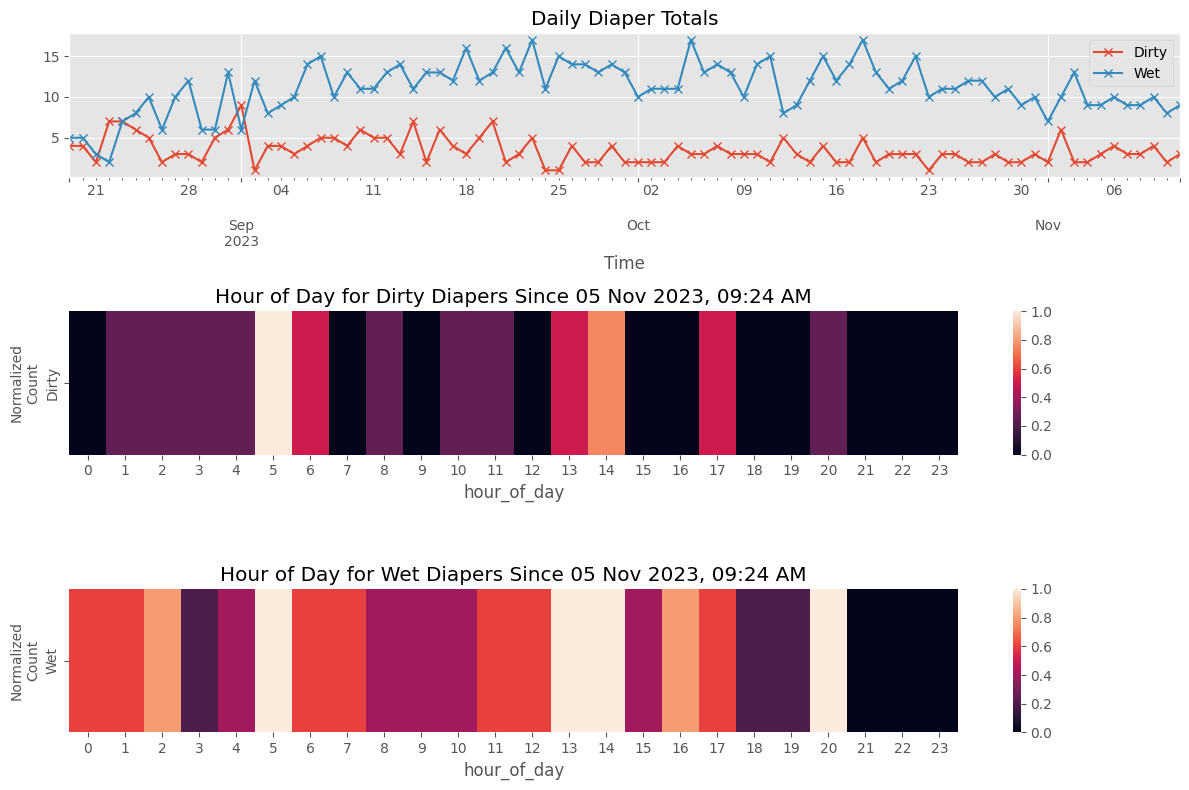

In [5]:
f,axes = plt.subplots(nrows=3,ncols=1,figsize=(12,8))
axes = axes.ravel()
ax = diaper_df[['Dirty','Wet']].resample('D').sum().iloc[:-1].plot(marker='x',ax=axes[0])
ax.set_title('Daily Diaper Totals')
tdf = (diaper_df.loc[analysis_flt]
       .drop(columns='Status')
       .groupby('hour_of_day')
       .sum()
       .reindex(list(range(0,24)),fill_value=0))
tdf = tdf/tdf.abs().max()

for ax,col in zip(axes[1:],['Dirty','Wet']):
    ax = sns.heatmap(data=tdf[[col]].transpose(),vmin=0,vmax=1,ax=ax)
    ax.set_ylabel('Normalized\nCount',fontsize=10)
    s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
    ax.set_title(f'Hour of Day for {col} Diapers Since {s}')
plt.tight_layout()
plt.savefig(os.path.join(figure_path,'diapers.png'),bbox_inches='tight')

## Weight

In [6]:
import statsmodels.api as sm

growth_df = get_data(files_dict['Andrew_growth'])
growth_df['days'] = [get_days_between(growth_df.index[0],x) for x in growth_df.index]
growth_df['sq_days'] = growth_df['days']*growth_df['days']
started_eating_filter = growth_df.days>2
model = sm.OLS(growth_df[started_eating_filter]['Weight (lbs.)'].values,
             sm.add_constant(growth_df[started_eating_filter][['days']].values))
res = model.fit()
display(res.summary())
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]
growth_df['pred'] = np.append(np.full(sum(~started_eating_filter), fill_value=np.nan),res.fittedvalues)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1452.
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           3.92e-17
Time:                        11:21:54   Log-Likelihood:                 15.762
No. Observations:                  18   AIC:                            -27.52
Df Residuals:                      16   BIC:                            -25.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7508      0.039     70.477      0.000       2.668       2.834
x1             0.0383      0.001     38.110      0.000       0.036       0.040
==============================================================================
Omnibus:                        0.054   Durbin-Watson:                   0.536
Prob(Omnibus):                  0.973   Jarque-Bera (JB):                0.077
Skew:                          -0.018   Prob(JB):                        0.962
Kurtosis:                       2.682   Cond. No.                         60.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

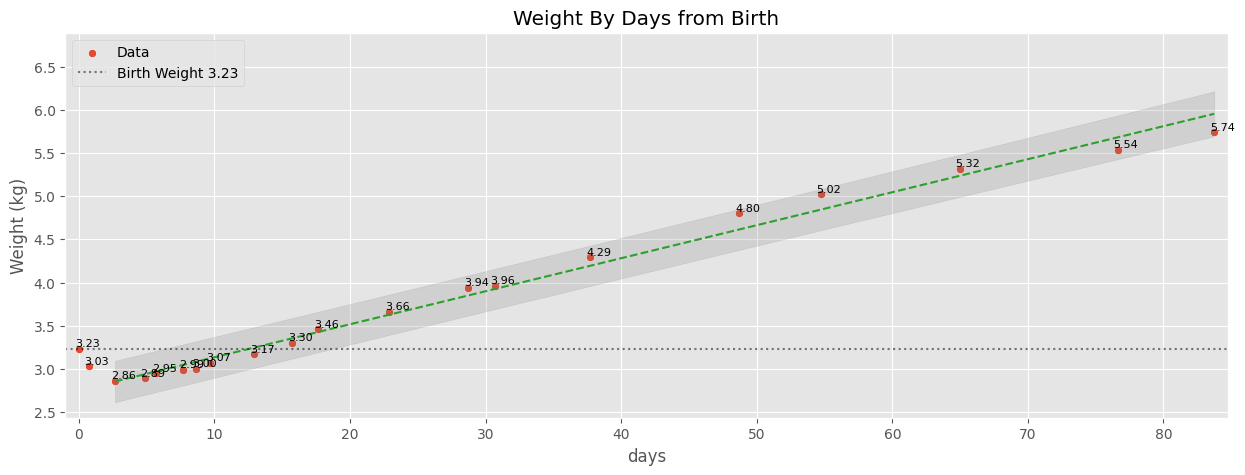

In [7]:
birth_weight = growth_df.at[growth_df.index[0],'Weight (lbs.)']
ax = sns.scatterplot(data=growth_df,x='days',y='Weight (lbs.)',label='Data')
ax = sns.lineplot(data=growth_df[started_eating_filter],x='days',y='pred',color='tab:green',
                  linestyle='dashed',label='_no_label_')
ax.axhline(birth_weight,label=f'Birth Weight {birth_weight:0.2f}',color='k',linestyle='dotted',alpha=0.5)
ax.fill_between(growth_df[started_eating_filter].days,
    iv_l, iv_u, color='tab:gray', alpha=0.2)

return_to_birth_weight = np.min(np.roots(np.poly1d([res.params[1],res.params[0] - birth_weight])))
r2bw_date = growth_df.index[0] + timedelta(days=return_to_birth_weight)
r2bw_date = datetime.strftime(r2bw_date,'%d %b %Y, %I:%M %p')
#ax.axvline(return_to_birth_weight,label = f'{return_to_birth_weight:0.2f} days',color='y',linestyle='dotted')
ax.set_title('Weight By Days from Birth')
yl = ax.get_ylim()
ax.set_xlim(-1,growth_df.at[growth_df.index[-1],'days']+1)
ax.set_ylim(yl[0],yl[1]+0.5)
for x, y in zip(growth_df.days, growth_df['Weight (lbs.)'].values):
    ax.text(x-0.3, y+0.025, f"{y:0.2f}", fontsize=8)
ax.set_ylabel('Weight (kg)')
ax.legend(loc='upper left')
#_=plt.savefig(os.path.join(figure_path,'weight.png'),bbox_inches='tight')

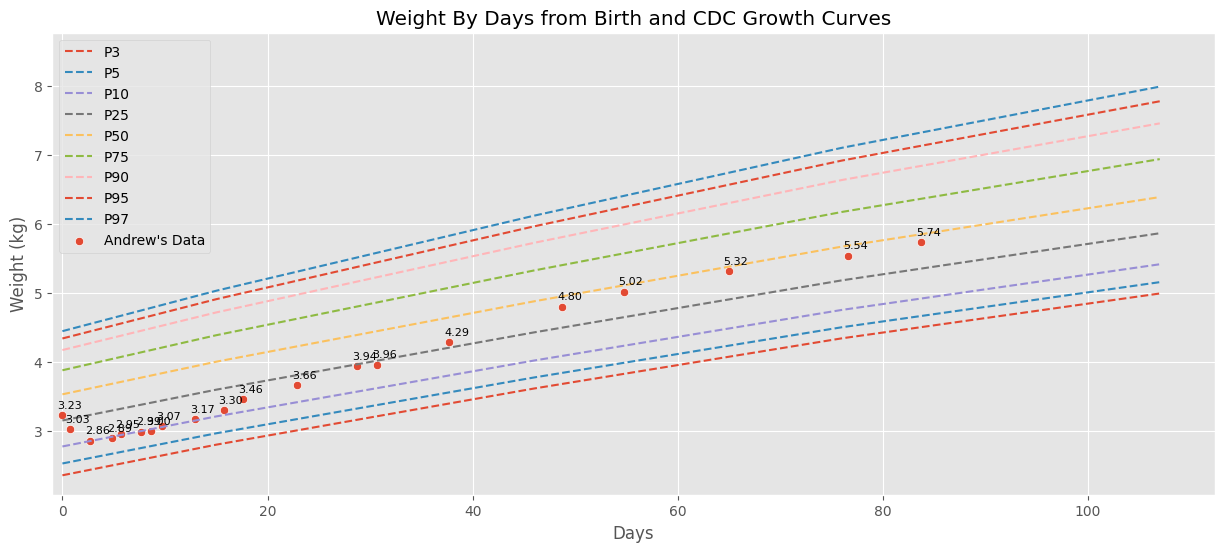

In [8]:
# CDC Data
SEX = 1 # 1 for male 2 for female

cdc_df = (pd.read_csv(files_dict['wtageinf'])
          .drop(columns=['L','M','S'])
          .assign(Days = lambda x: (x['Agemos']*365.25/12.0).apply(np.round).astype(int)))
cdc_df = cdc_df[cdc_df.Sex == SEX].drop(columns=['Sex','Agemos']).set_index('Days')
next_cdc_idx = list(filter(lambda x: x>int(growth_df.days.max() + 10),list(cdc_df.index)))[0]

# plot data
ax = cdc_df.loc[:next_cdc_idx].plot(figsize=(15,6),linestyle='dashed')
ax = sns.scatterplot(data=growth_df,x='days',y='Weight (lbs.)',label='Andrew\'s Data',ax=ax)

ax.set_title('Weight By Days from Birth and CDC Growth Curves')

# add point labels
yl = ax.get_ylim()
xl = ax.get_xlim()
ax.set_xlim(-1,xl[1])
ax.set_ylim(yl[0],yl[1]+0.5)
for x, y in zip(growth_df.days, growth_df['Weight (lbs.)'].values):
    ax.text(x-0.5, y+0.1, f"{y:0.2f}", fontsize=8)
ax.set_ylabel('Weight (kg)')
ax.legend(loc='upper left')
_=plt.savefig(os.path.join(figure_path,'weight.png'),bbox_inches='tight')

## Feeding Habits

,Formula (oz.),Milk (oz.),Amount (oz.),Time Between Feeds (min)
count,63.000000,0.0,63.000000,63.000000
mean,2.828571,NaN,2.828571,161.333333
std,1.135381,NaN,1.135381,66.777918
min,0.500000,NaN,0.500000,83.000000
25%,2.000000,NaN,2.000000,120.000000
50%,3.000000,NaN,3.000000,147.000000
75%,3.500000,NaN,3.500000,167.500000
max,5.500000,NaN,5.500000,365.000000


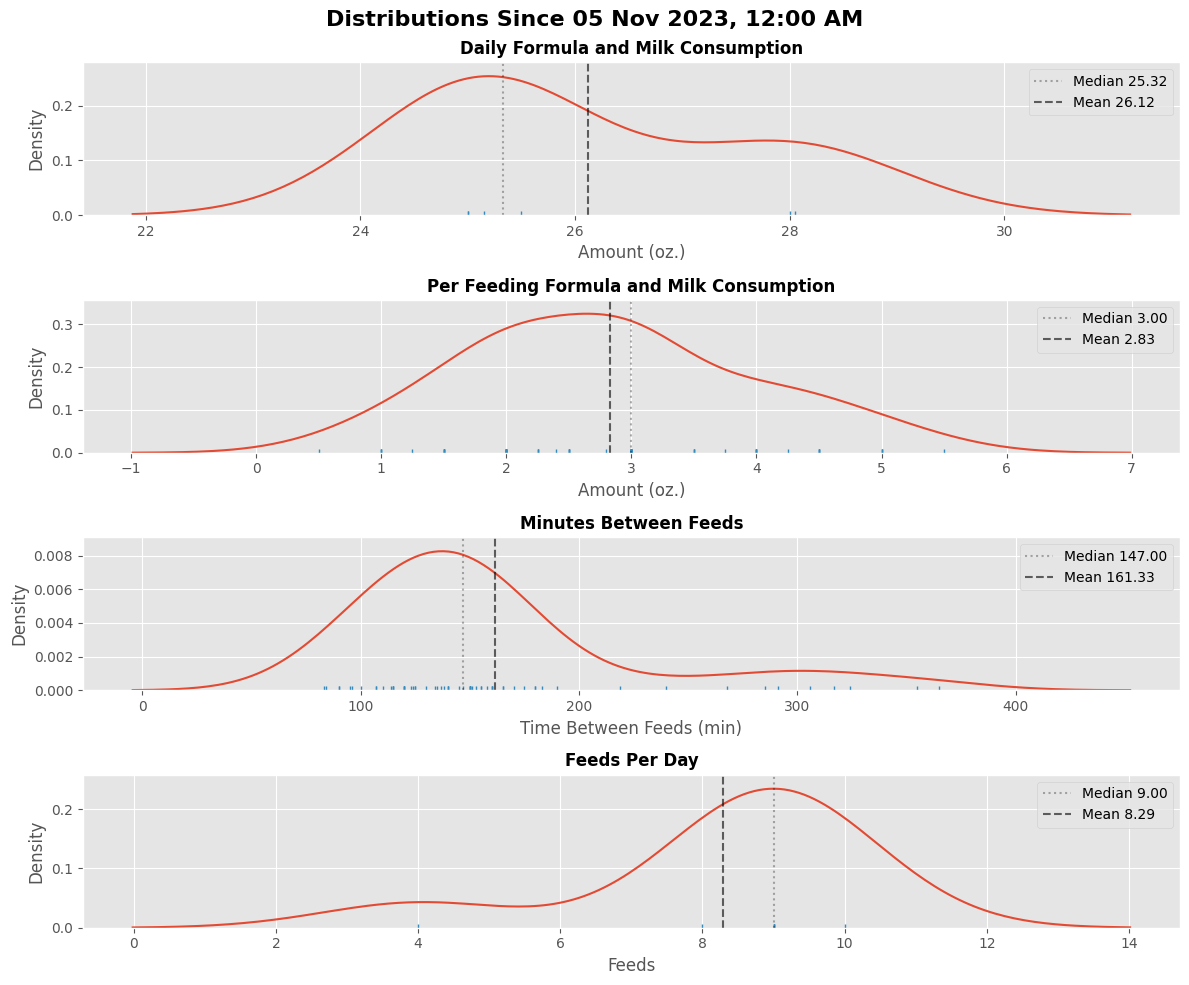

In [9]:
feeding_df = (pd.concat((get_data(files_dict['Andrew_formula']).rename(columns={'Amount (oz.)':'Formula (oz.)'}),
                        get_data(files_dict['Andrew_expressed']).rename(columns={'Amount (oz.)':'Milk (oz.)'})),axis=1)
                        .drop(columns=['Note'])
                        .assign(Amount = lambda x: x['Formula (oz.)'].fillna(x['Milk (oz.)']))
                        .rename(columns={'Amount':'Amount (oz.)'})
                        .sort_index())
start_date, analysis_flt = get_recent_filter(feeding_df)
feeding_df['hour_of_day'] = [x.hour for x in feeding_df.index]
feeding_df['Time Between Feeds (min)'] = feeding_df.index
feeding_df['Time Between Feeds (min)'] = feeding_df['Time Between Feeds (min)'].diff().fillna(timedelta(seconds=0))
feeding_df['Time Between Feeds (min)'] = feeding_df['Time Between Feeds (min)'].apply(lambda x: x.seconds//60)
feeding_df['Feeds'] = 0
feeding_df['Feeds'].loc[~feeding_df['Amount (oz.)'].isna()] = 1
tdf = feeding_df.resample('D').sum()[['Amount (oz.)']]
ts,tf = get_recent_filter(tdf)
tdf = tdf.loc[tf & (tdf.index<today)]

# analyze recent data
feeding_df['rolling mean amount'] = feeding_df['Amount (oz.)'].rolling(to_analyze).mean()
feeding_df['rolling median amount'] = feeding_df['Amount (oz.)'].rolling(to_analyze).median()

feeding_df['rolling mean time between feeds'] = feeding_df['Time Between Feeds (min)'].rolling(to_analyze).mean()
feeding_df['rolling median time between feeds'] = feeding_df['Time Between Feeds (min)'].rolling(to_analyze).median()

stats = feeding_df.loc[analysis_flt].describe()
display(stats[['Formula (oz.)','Milk (oz.)','Amount (oz.)','Time Between Feeds (min)']])
mean = stats.at['mean','Amount (oz.)']
median = stats.at['50%','Amount (oz.)']
mean_time = stats.at['mean','Time Between Feeds (min)']
median_time = stats.at['50%','Time Between Feeds (min)']
mean_total = tdf.describe().at['mean','Amount (oz.)']
median_total = tdf.describe().at['50%','Amount (oz.)']

# plot
f,axes = plt.subplots(ncols=1,nrows=4,figsize=(12,10))
ax0,ax1,ax2,ax3 = axes.ravel()
ax=sns.kdeplot(data=tdf,x='Amount (oz.)',ax=ax0)
ax=sns.rugplot(data=tdf,x='Amount (oz.)',ax=ax)
ax.axvline(median_total,color='k',linestyle='dotted',label=f'Median {median_total:0.2f}',alpha=0.3)
ax.axvline(mean_total,color='k',linestyle='dashed',label=f'Mean {mean_total:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Daily Formula and Milk Consumption',fontweight='bold',fontsize=12)

ax=sns.kdeplot(data=feeding_df.loc[analysis_flt],x='Amount (oz.)',ax=ax1)
ax=sns.rugplot(data=feeding_df.loc[analysis_flt],x='Amount (oz.)',ax=ax)
ax.axvline(median,color='k',linestyle='dotted',label=f'Median {median:0.2f}',alpha=0.3)
ax.axvline(mean,color='k',linestyle='dashed',label=f'Mean {mean:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Per Feeding Formula and Milk Consumption',fontweight='bold',fontsize=12)

ax=sns.kdeplot(data=feeding_df.loc[analysis_flt],x='Time Between Feeds (min)',ax=ax2)
ax=sns.rugplot(data=feeding_df.loc[analysis_flt],x='Time Between Feeds (min)',ax=ax)
ax.axvline(median_time,color='k',linestyle='dotted',label=f'Median {median_time:0.2f}',alpha=0.3)
ax.axvline(mean_time,color='k',linestyle='dashed',label=f'Mean {mean_time:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Minutes Between Feeds',fontweight='bold',fontsize=12)


daily_feeds_df = feeding_df.resample('D').sum()
daily_feeds_df['rolling mean feeds per day'] = daily_feeds_df['Feeds'].rolling(to_analyze).mean()
daily_feeds_df['rolling median feeds per day'] = daily_feeds_df['Feeds'].rolling(to_analyze).median()
start_date,analysis_flt = get_recent_filter(daily_feeds_df)
mean_feeds = daily_feeds_df.loc[analysis_flt].Feeds.mean()
median_feeds = daily_feeds_df.loc[analysis_flt].Feeds.median()
ax=sns.kdeplot(data=daily_feeds_df.loc[analysis_flt],x='Feeds',ax=ax3)
ax=sns.rugplot(data=daily_feeds_df.loc[analysis_flt],x='Feeds',ax=ax)
ax.axvline(median_feeds,color='k',linestyle='dotted',label=f'Median {median_feeds:0.2f}',alpha=0.3)
ax.axvline(mean_feeds,color='k',linestyle='dashed',label=f'Mean {mean_feeds:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Feeds Per Day',fontweight='bold',fontsize=12)

plt.suptitle(f'Distributions Since {s}',fontweight='bold',fontsize=16)
plt.tight_layout()

_=plt.savefig(os.path.join(figure_path,'feeding_distribution.png'),bbox_inches='tight')

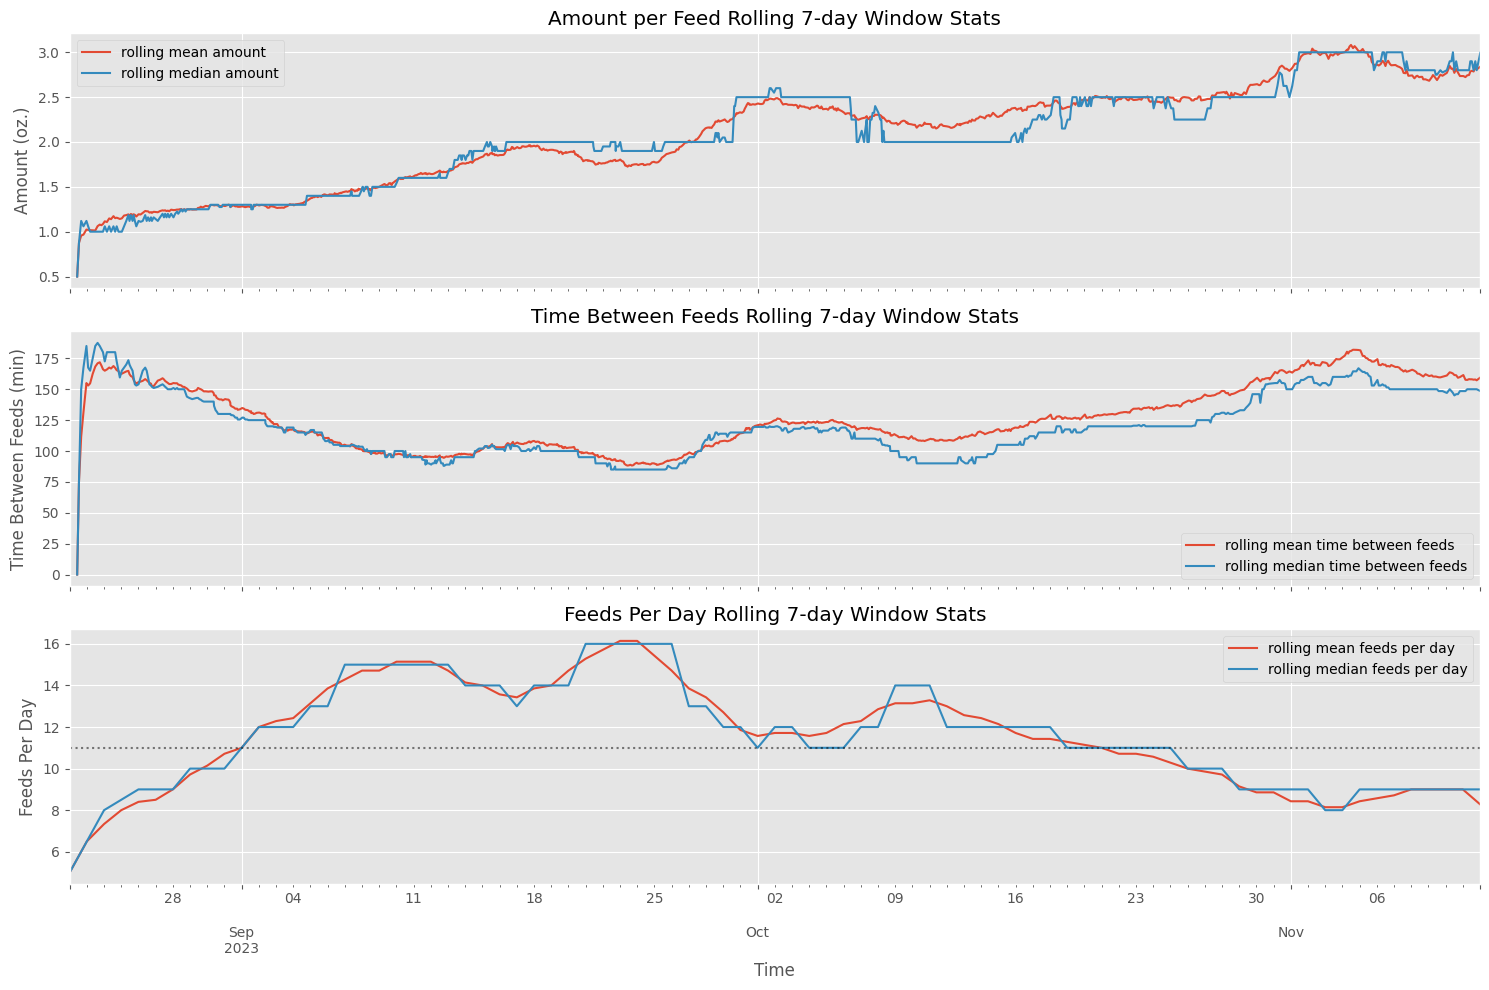

In [10]:
f,axes = plt.subplots(ncols=1,nrows=3,figsize=(15,10),sharex=True)
ax1,ax2,ax3 = axes.ravel()
ax = feeding_df[['rolling mean amount','rolling median amount']].dropna().plot(ax=ax1)
ax.set_ylabel('Amount (oz.)')
ax.set_title(f'Amount per Feed Rolling {to_analyze.days}-day Window Stats')

ax = feeding_df[['rolling mean time between feeds','rolling median time between feeds']].dropna().plot(ax=ax2)
ax.set_ylabel('Time Between Feeds (min)')
ax.set_title(f'Time Between Feeds Rolling {to_analyze.days}-day Window Stats')

ax = daily_feeds_df[['rolling mean feeds per day','rolling median feeds per day']].dropna().plot(ax=ax3)
ax.axhline(11,label='Scheduled Target',linestyle='dotted',color='k',alpha=0.5)
ax.set_ylabel('Feeds Per Day')
ax.set_title(f'Feeds Per Day Rolling {to_analyze.days}-day Window Stats')
plt.tight_layout()
_=plt.savefig(os.path.join(figure_path,'feeding_rolling.png'),bbox_inches='tight')

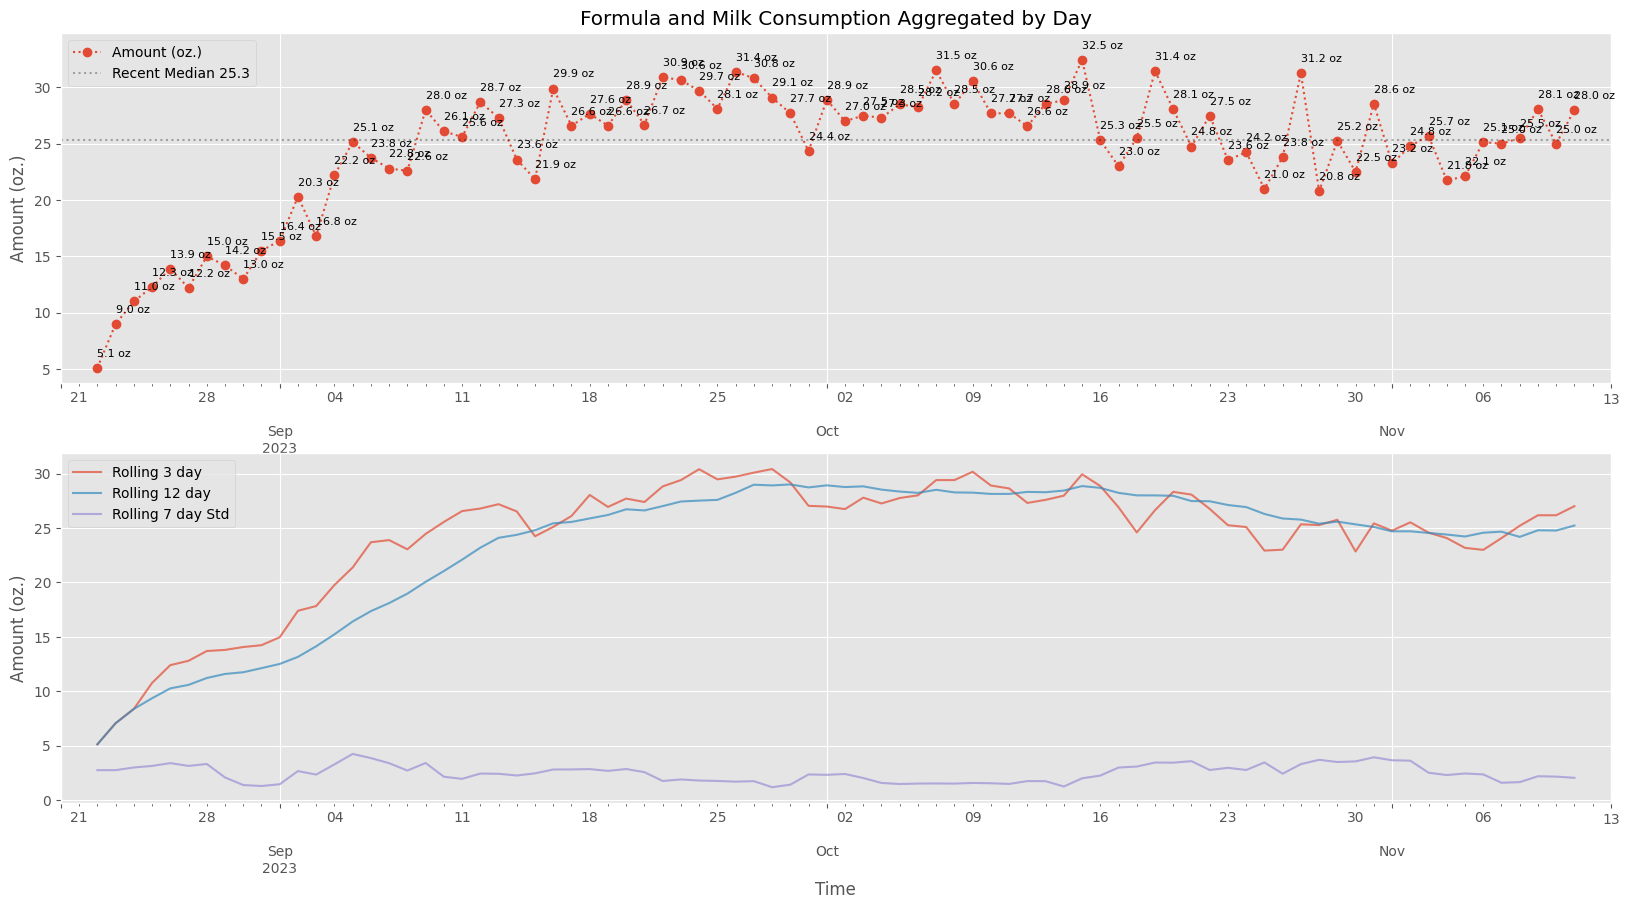

In [11]:
tdf = feeding_df.resample('D').sum()[['Amount (oz.)']]
tdf['Rolling 3 day'] = tdf['Amount (oz.)'].rolling('3D').mean()
tdf['Rolling 12 day'] = tdf['Amount (oz.)'].rolling('12D').mean()
tdf['Rolling 7 day Std'] = tdf['Amount (oz.)'].rolling('7D').std()
tdf = pd.DataFrame(tdf.loc[tdf.index<today]) # drop incomplete day
tdf['x'] = range(1,len(tdf.index)+1)
f,axes = plt.subplots(nrows=2,ncols=1,figsize=(20,10))
axes = axes.ravel()
ax = tdf['Amount (oz.)'].plot(marker='o',linestyle='dotted',ax=axes[0])
ax.set_xlim(tdf.index[0]-timedelta(days=2),tdf.index[-1]+timedelta(days=2))
x1 = ax.get_xlim()
yl = ax.get_ylim()
offset = 1.0
ax.set_ylim(yl[0],yl[1]+offset)
for x, y in zip(tdf.index, tdf['Amount (oz.)'].values):
    ax.text(x, y+offset, f"{y:0.1f} oz", fontsize=8)
ax.axhline(median_total,label=f'Recent Median {median_total:0.1f}',linestyle='dotted',color='k',alpha=0.3)
ax.set_ylabel('Amount (oz.)')
ax.legend(loc='upper left')
ax.set_title('Formula and Milk Consumption Aggregated by Day')
ax = tdf[['Rolling 3 day','Rolling 12 day','Rolling 7 day Std']].fillna(method='backfill').plot(ax=axes[1],alpha=0.7)
ax.set_xlim(*x1)
ax.set_ylabel('Amount (oz.)')
plt.tight_layout
_=plt.savefig(os.path.join(figure_path,'feeding_daily_totals.png'),bbox_inches='tight')

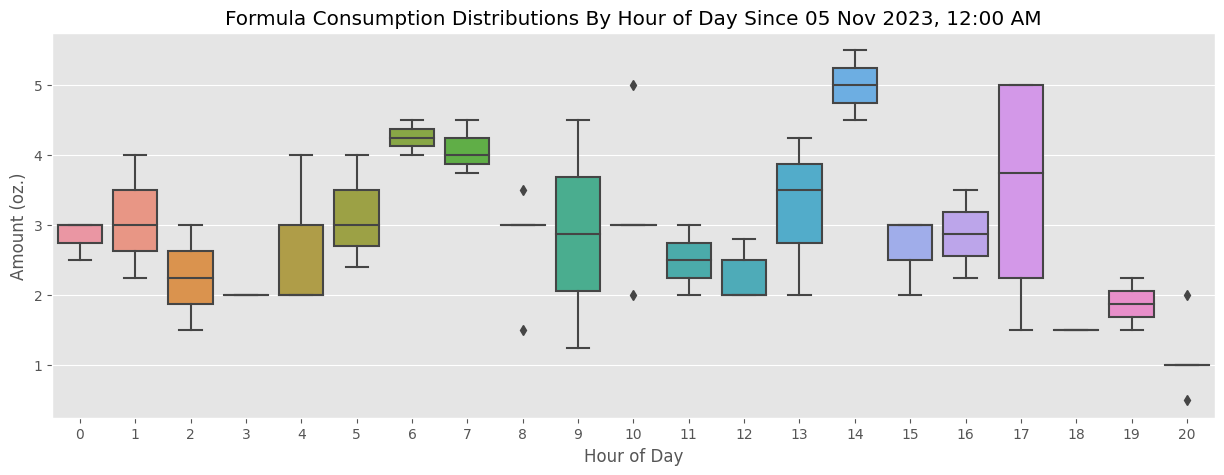

In [12]:
start_date,analysis_flt = get_recent_filter(feeding_df)
ax=sns.boxplot(data=feeding_df.loc[analysis_flt],y='Amount (oz.)',x='hour_of_day')
ax.set_title(f'Formula Consumption Distributions By Hour of Day Since {s}')
ax.set_xlabel('Hour of Day')
_=plt.savefig(os.path.join(figure_path,'feeding_by_hour.png'),bbox_inches='tight')

## Sleep

In [13]:
def time_of_day(hour):
    if hour < 7 or hour > 19:
        return 'night'
    else:
        return 'day'
sleep_df = get_data(files_dict['Andrew_sleep'])
sleep_df['Time of Day'] = [time_of_day(x.hour) for x in sleep_df.index]
sleep_df[~sleep_df.Note.isna()]


,Duration (min),Note,Time of Day
Time,,,
2023-10-27 18:25:00,95,wifey beat son with wet noodle to wake him up,day
2023-10-27 20:35:00,180,woke himself,night
2023-10-28 00:17:00,138,Stirred in his sleep,night
2023-10-28 02:55:00,45,Woke himself crying,night
2023-11-02 18:26:00,97,I woke to feed,day
2023-11-05 16:20:00,220,Woke him to feed…he’s barely awake only 1oz,day
2023-11-06 16:55:00,72,Walks him to eat,day
2023-11-06 18:52:00,76,Woke him up for feed,day
2023-11-07 18:25:00,94,Woke up on his own crying,day


In [14]:
start_date, recent_filter = get_recent_filter(df=sleep_df)
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
print('Full History Stats')
display(sleep_df.groupby('Time of Day').describe())
print(f'Recent Stats Since {s}')
display(sleep_df.loc[recent_filter].groupby('Time of Day').describe())

Full History Stats


Duration (min)                                                \
                     count       mean        std  min   25%   50%    75%   
Time of Day                                                                
day                  131.0  43.763359  46.698185  1.0  15.5  34.0   51.0   
night                 81.0  87.135802  90.990900  2.0  13.0  54.0  124.0   

                    
               max  
Time of Day         
day          303.0  
night        391.0

Recent Stats Since 05 Nov 2023, 08:33 AM


Duration (min)                                                \
                     count       mean        std  min   25%   50%    75%   
Time of Day                                                                
day                   57.0  36.280702  35.912470  1.0  10.0  31.0   46.0   
night                 28.0  95.357143  97.964927  4.0  23.0  56.0  135.5   

                    
               max  
Time of Day         
day          220.0  
night        315.0

In [15]:
mean,median = sleep_df[sleep_df['Time of Day'] == 'day'].describe().loc[['mean','50%']].values

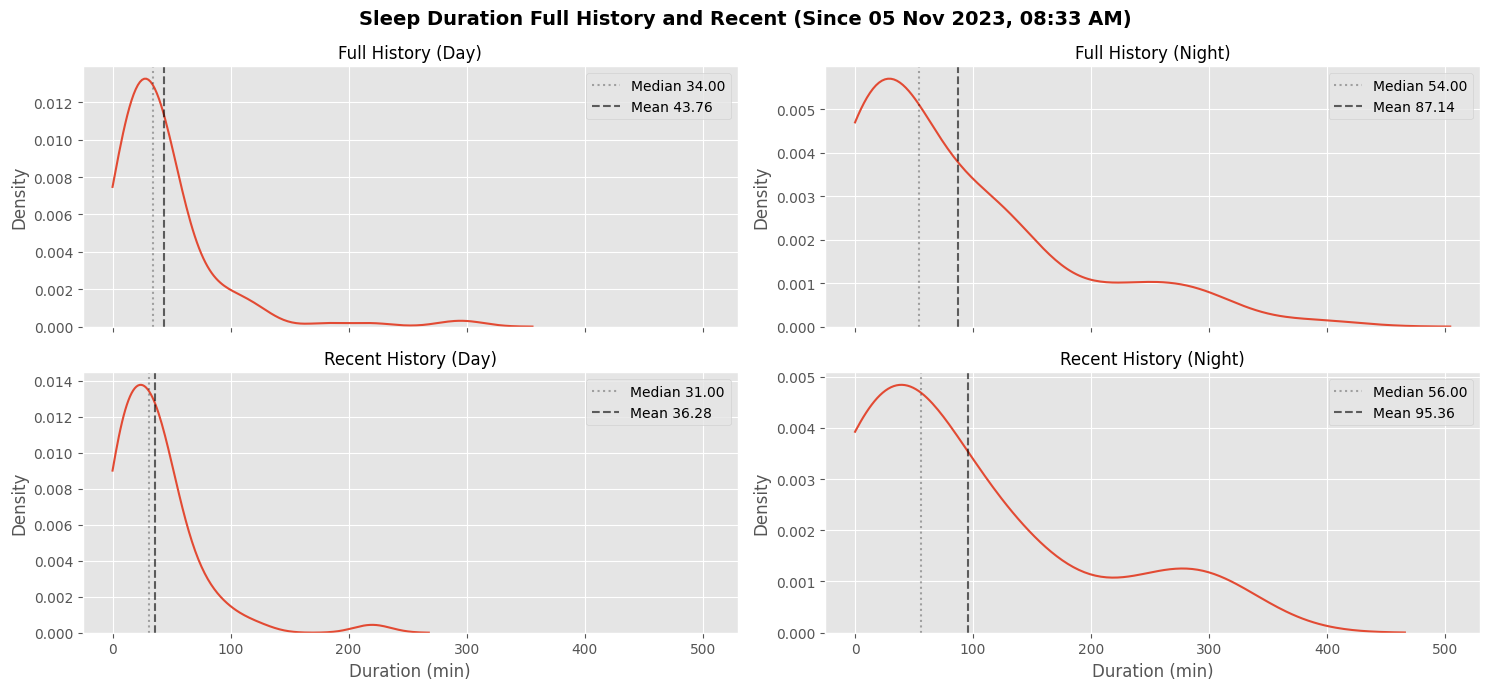

In [16]:
def plot_dist_with_mean_median(df,col,ax,title):
    mean,median = df.describe()[col].loc[['mean','50%']].values
    ax = sns.kdeplot(df[col],clip=(0,np.inf),ax=ax)
    ax.axvline(median,color='k',linestyle='dotted',label=f'Median {median:0.2f}',alpha=0.3)
    ax.axvline(mean,color='k',linestyle='dashed',label=f'Mean {mean:0.2f}',alpha=0.6)
    ax.legend()
    ax.set_title(title,fontsize=12)
    return ax

f,axes = plt.subplots(nrows=2,ncols=2,figsize=(15,7),sharex=True)
axes = axes.ravel().reshape(-1,2)
plot_dist_with_mean_median(sleep_df[sleep_df['Time of Day'] == 'day'],
                           'Duration (min)',axes[0,0],'Full History (Day)')
plot_dist_with_mean_median(sleep_df[sleep_df['Time of Day'] == 'night'],
                           'Duration (min)',axes[0,1],'Full History (Night)')
plot_dist_with_mean_median(sleep_df[(sleep_df['Time of Day'] == 'day')&recent_filter],
                           'Duration (min)',axes[1,0],'Recent History (Day)')
plot_dist_with_mean_median(sleep_df[(sleep_df['Time of Day'] == 'night')&recent_filter],
                           'Duration (min)',axes[1,1],'Recent History (Night)')
plt.suptitle(f'Sleep Duration Full History and Recent (Since {s})',
             fontsize=14,fontweight='bold')
plt.tight_layout()
_=plt.savefig(os.path.join(figure_path,'sleep_duration_day_night.png'),bbox_inches='tight')